In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
np.seterr(divide="ignore")
import logging
import pickle
import glob

import multiprocessing as mp


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

from recnn.preprocessing import rewrite_content
from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract
from recnn.preprocessing import sequentialize_by_pt
from recnn.preprocessing import randomize
from recnn.preprocessing import multithreadmap


%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

# Plotting functions

In [52]:

def load_tf(filename_train, preprocess=None, n_events_train=-1):
    # Make training data
    print("Loading training data...")

    X, y = np.load(filename_train)
    X=np.array(X).astype(dict)
    y = np.array(y).astype(int)

    if n_events_train > 0:
        indices = check_random_state(123).permutation(len(X))[:n_events_train]
        X = [X[i] for i in indices]
        y = y[indices]

    print("\tfilename = %s" % filename_train)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
    X = np.array(X)
    # Preprocessing 
    print("Preprocessing...")
    X = multithreadmap(rewrite_content,X)

    if preprocess:
        X = multithreadmap(preprocess,X)

    X = multithreadmap(permute_by_pt,X)
    X = multithreadmap(extract,X)
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))
    return tf

def load_test(tf, filename_test, preprocess=None, cropping=False):
    # Make test data 
    print("Loading test data...")

    X, y = np.load(filename_test)
    X=np.array(X).astype(dict)
    y = np.array(y).astype(int)

    print("\tfilename = %s" % filename_test)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = multithreadmap(rewrite_content,X)
    
    if preprocess:
        X = multithreadmap(preprocess,X)
        
    X = multithreadmap(permute_by_pt,X)
    X = multithreadmap(extract,X)

    for jet in X:
        jet["content"] = tf.transform(jet["content"])

    if not cropping:
        return X, y, 1
        
    # Cropping
    X_ = [j for j in X if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]
    y_ = [y[i] for i, j in enumerate(X) if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]

    X = X_
    y = y_
    y = np.array(y)
    
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
    
    # Weights for flatness in pt
    w = np.zeros(len(y))
    
    X0 = [X[i] for i in range(len(y)) if y[i] == 0]
    pdf, edges = np.histogram([j["pt"] for j in X0], density=True, range=[250, 300], bins=50)
    pts = [j["pt"] for j in X0]
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
    w[y==0] = inv_w
        
    X1 = [X[i] for i in range(len(y)) if y[i] == 1]
    pdf, edges = np.histogram([j["pt"] for j in X1], density=True, range=[250, 300], bins=50)
    pts = [j["pt"] for j in X1]
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
    w[y==1] = inv_w
        
    return X, y, w

In [53]:
from recnn.recnn import grnn_transform_simple
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated
#from recnn.recnn import grnn_predict_simple_join


def predict(X, filename, func=grnn_predict_simple):
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return y_pred


def evaluate_models(X, y, w, pattern, func=grnn_predict_simple):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
        print("Loading %s" % filename),
            
        y_pred = predict(X, filename, func=func)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
        fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
         
    print("Mean ROC AUC = %.4f" % np.mean(rocs))
        
    return rocs, fprs, tprs

def build_rocs(prefix_train, prefix_test, model_pattern, preprocess=None, gated=False):
    tf = load_tf("/data/conda/recnn/data/picklefiles/preprocessed_training_set_anti-kt_train.pickle", preprocess=preprocess)
    X, y, w = load_test(tf, "/data/conda/recnn/data/picklefiles/preprocessed_training_set_anti-kt_test.pickle", preprocess=preprocess) 
    
    if not gated:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "/data/conda/recnn/models/model_anti-kt.pickle")
    else:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "/data/conda/recnn/models/model_anti-kt.pickle", func=grnn_predict_gated)
        
    return rocs, fprs, tprs

In [54]:
def remove_outliers(rocs, fprs, tprs):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)

    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)

    inv_fprs = np.array(inv_fprs)
    scores = inv_fprs[:, 225]
    
    p25 = np.percentile(scores, 1 / 6. * 100.)
    p75 = np.percentile(scores, 5 / 6. * 100)
    
    robust_mean = np.mean([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    robust_std = np.std([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    
    indices = [i for i in range(len(scores)) if robust_mean - 3*robust_std <= scores[i] <= robust_mean + 3*robust_std]
    
    new_r, new_f, new_t = [], [], []
    
    for i in indices:
        new_r.append(rocs[i])
        new_f.append(fprs[i])
        new_t.append(tprs[i])
    
    return new_r, new_f, new_t


def report_score(rocs, fprs, tprs, label, latex=False, input="particles", short=False):       
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    if not latex:
        print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, 
                                                                       np.mean(rocs), 
                                                                       np.std(rocs),
                                                                       np.mean(inv_fprs[:, 225]),
                                                                       np.std(inv_fprs[:, 225])))
    else:
        if not short:
            print("%10s \t& %30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (input,
                   label,
                   np.mean(rocs), 
                   np.std(rocs),
                   np.mean(inv_fprs[:, 225]),
                   np.std(inv_fprs[:, 225])))
        else:
            print("%30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (label,
                   np.mean(rocs), 
                   np.std(rocs),
                   np.mean(inv_fprs[:, 225]),
                   np.std(inv_fprs[:, 225])))
        
def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlabel("Signal efficiency")
    plt.ylabel("1 / Background efficiency")
    plt.xlim([0.1, 1.0])
    plt.ylim(1, 500)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Count parameters

In [55]:
def count(params):
    def _count(thing):
        if isinstance(thing, list):
            c = 0
            for stuff in thing:
                c += _count(stuff)
            return c 

        elif isinstance(thing, np.ndarray):
            return np.prod(thing.shape)
    
    c = 0
    for k, v in params.items():
        c += _count(v)
    return c
    
# Simple vs gated
fd = open("/data/conda/recnn/models/model_anti-kt.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Simple =", count(params))   

#fd = open("../models/jet-study-2/model-w-g-antikt-kt-1.pickle", "rb")
#params = pickle.load(fd)
#fd.close()
#print("Gated =", count(params))

('Simple =', 48761)


In [56]:
# double
# Simple vs gated
fd = open("/data/conda/recnn/models/model_anti-kt.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Simple =", count(params))   

#fd = open("../models/jet-study-2/model-w-gd-antikt-kt-1.pickle", "rb")
#params = pickle.load(fd)
#fd.close()
#print("Gated =", count(params))

('Simple =', 48761)


# Embedding visualization

In [57]:
prefix_train = "antikt-kt"
prefix_test = prefix_train
tf = load_tf("/data/conda/recnn/data/npyfiles/MoreStat_testtype.npy")
X, y, w = load_test(tf, "/data/conda/recnn/data/npyfiles/MoreStat_testtype.npy")

Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...


In [58]:
fd = open("/data/conda/recnn/models/model_anti-kt.pickle", "rb")
params = pickle.load(fd)
fd.close()

In [59]:
Xt = grnn_transform_simple(params, X[:5000])
Xt

array([[3.08581996e-01, 3.74091210e+00, 2.05860337e+00, ...,
        7.39066774e-01, 1.03669609e+00, 1.08103558e+00],
       [0.00000000e+00, 2.09605463e+02, 1.56818405e+02, ...,
        1.89194366e+02, 1.18790238e+02, 1.39315712e+02],
       [0.00000000e+00, 1.50092770e+01, 1.03868326e+01, ...,
        1.24782817e+01, 8.16759314e+00, 9.91831867e+00],
       ...,
       [0.00000000e+00, 1.35950938e+02, 1.01980957e+02, ...,
        1.21974285e+02, 7.70753016e+01, 8.94118356e+01],
       [0.00000000e+00, 3.91574209e+01, 2.78927438e+01, ...,
        3.38888370e+01, 2.13490433e+01, 2.50936441e+01],
       [0.00000000e+00, 0.00000000e+00, 7.92018522e-03, ...,
        7.20634050e-01, 1.08364992e+00, 2.76039234e-01]])

In [60]:
from sklearn.manifold import TSNE
Xtt = TSNE(n_components=2).fit_transform(Xt)

IndexError: index 458 is out of bounds for axis 0 with size 458

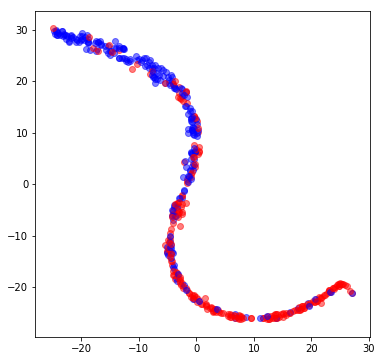

In [61]:
fig=plt.figure()
for i in range(5000):
    plt.scatter(Xtt[i, 0], Xtt[i, 1], color="b" if y[i] == 1 else "r", alpha=0.5)

fig.set_size_inches(6.69291,4)
plt.savefig("test.png",dpi=600)
plt.show()

IndexError: index 458 is out of bounds for axis 0 with size 458

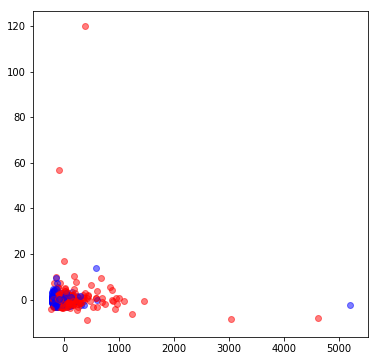

In [62]:
from sklearn.decomposition import PCA
Xtt = PCA(n_components=2).fit_transform(Xt)
fig=plt.figure()

for i in range(5000):
    plt.scatter(Xtt[i, 0], Xtt[i, 1], color="b" if y[i] == 1 else "r", alpha=0.5)
fig.set_size_inches(6.69291,4)
plt.savefig("test2.png",dpi=600)
plt.show()

# Generate all ROCs

In [63]:
for pattern, gated in [
        # Simple
        ## Particles
        #("antikt-kt", False),
        #("antikt-cambridge", False),
        #("antikt-antikt", False),
        #("antikt-random", False),
        #("antikt-seqpt", False),
        #("antikt-seqpt-reversed", False),
        ## Towers
        #("antikt-kt-delphes", False),
        #("antikt-cambridge-delphes", False),
        #("antikt-antikt-delphes", False),
        #("antikt-random-delphes", False),
        #("antikt-seqpt-delphes", False),
        #("antikt-seqpt-reversed-delphes", False),
        ## Images
        #("antikt-kt-images", False),

        # Gated
        ## Particles
        ("antikt-kt", True),
        #("antikt-antikt", True),
        #("antikt-seqpt", True),
        #("antikt-seqpt-reversed", True),
        #("antikt-cambridge", True),
        #("antikt-random", True),
        ## Towers
        #("antikt-kt-delphes", True),
        #("antikt-antikt-delphes", True),
        #("antikt-seqpt-delphes", True),
        #("antikt-seqpt-reversed-delphes", True),
        #("antikt-cambridge-delphes", True),
        #("antikt-random-delphes", True),
        ## Images
        #("antikt-kt-images", True)
    ]:
    r, f, t = build_rocs(pattern, pattern, pattern, gated=gated)
    
    # Save
    fd = open("/data/conda/recnn/roccurves/model_anti-kt.pickle", "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading /data/conda/recnn/models/model_anti-kt.pickle ROC AUC = 0.9293
Mean ROC AUC = 0.9293


In [65]:
# sd/gd == contatenate embeddings of h1_L + h1_R
for pattern, gated in [
        # Simple
        ## Particles
        ("antikt-kt", False),
        ## Towers
        ("antikt-kt-delphes", False),
        ## Images
        ("antikt-kt-images", False),

        # Gated
        ## Particles
        ("antikt-kt", True),
        ## Towers
        ("antikt-kt-delphes", True),
        ## Images
        ("antikt-kt-images", True)
    ]:
    r, f, t = build_rocs(pattern, pattern, pattern, gated=gated)
    
    # Save
    fd = open("/data/conda/recnn/roccurves/model_anti-kt_bis(nani).pickle", "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading /data/conda/recnn/models/model_anti-kt.pickle ROC AUC = 0.7703
Mean ROC AUC = 0.7703
Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading /data/conda/recnn/models/model_anti-kt.pickle ROC AUC = 0.7703
Mean ROC AUC = 0.7703
Loading training data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading test data...
	filename = /data/conda/recnn/data/npyfiles/MoreStat_testtype.npy
	X size = 458
	y size = 458
Preprocessing...
Loading /d

# Table

In [66]:
### We need to complitely redefine this.

for pattern, gated, label in [
        """
        # Simple
        ## Particles
        #("antikt-kt", False, "RNN $k_t$"),
        #("antikt-cambridge", False, "RNN C/A"),
        #("antikt-antikt", False, "RNN anti-$k_t$"),
        #("antikt-random", False, "RNN random"),
        #("antikt-seqpt", False, "RNN asc-$p_T$"),
        #("antikt-seqpt-reversed", False, "RNN desc-$p_T$"),
        ## Towers
        #("antikt-kt-delphes", False, "RNN $k_t$"),
        ("antikt-cambridge-delphes", False, "RNN C/A"),
        ("antikt-antikt-delphes", False, "RNN anti-$k_t$"),
        ("antikt-random-delphes", False, "RNN random"),
        ("antikt-seqpt-delphes", False, "RNN asc-$p_T$"),
        ("antikt-seqpt-reversed-delphes", False, "RNN desc-$p_T$"),
        ## Images
        ("antikt-kt-images", False, "RNN $k_t$"),

        # Gated
        ## Particles
        """
        ("antikt-kt", True, "RNN $k_t$ (gated)"),
        #("antikt-cambridge", True, "RNN C/A (gated)"),
        #("antikt-antikt", True, "RNN anti-$k_t$ (gated)"),
        #("antikt-random", True, "RNN random (gated)"),
        #("antikt-seqpt", True, "RNN asc-$p_T$ (gated)"),
        #("antikt-seqpt-reversed", True, "RNN desc-$p_T$ (gated)"),
        ## Towers
        #("antikt-kt-delphes", True, "RNN $k_t$ (gated)"),
        #("antikt-cambridge-delphes", True, "RNN C/A (gated)"),
        #("antikt-antikt-delphes", True, "RNN anti-$k_t$ (gated)"),
        #("antikt-random-delphes", True, "RNN random (gated)"),
        #("antikt-seqpt-delphes", True, "RNN asc-$p_T$ (gated)"),
        #("antikt-seqpt-reversed-delphes", True, "RNN desc-$p_T$ (gated)"),
    
        # Images
        #("antikt-kt-images", False, "RNN $k_t$"),
        #("antikt-kt-images", True, "RNN $k_t$ (gated)")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label, 
                 latex=True, 
                 input="particles" if "delphes" not in pattern and "images" not in pattern else "towers")

IOError: [Errno 2] No such file or directory: '../models/jet-study-2/rocs/rocs-s-antikt-kt.pickle'

In [ ]:
for pattern, gated, label in [
        # Simple
        ## Particles
        ("antikt-kt", False, "RNN $k_t$"),
        ## Towers
        ("antikt-kt-delphes", False, "RNN $k_t$"),
        ## Images
        ("antikt-kt-images", False, "RNN $k_t$"),

        # Gated
        ## Particles
        ("antikt-kt", True, "RNN $k_t$ (gated)"),
        ## Towers
        ("antikt-kt-delphes", True, "RNN $k_t$ (gated)"),
        # Images
        ("antikt-kt-images", True, "RNN $k_t$ (gated)")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("sd" if not gated else "gd", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label, 
                 latex=True, 
                 input="particles" if "delphes" not in pattern and "images" not in pattern else "towers")

# Plots

               RNN $k_t$ (gated)	ROC AUC=0.9293+-0.00	1/FPR@TPR=0.5=33.29+-0.00


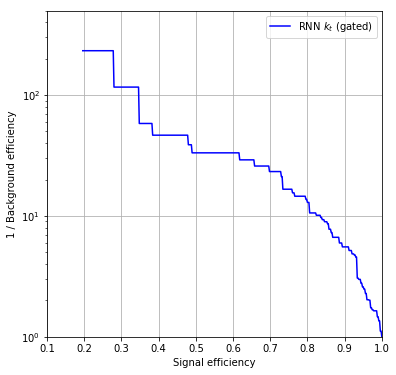

In [68]:
# Simple vs gated
for pattern, gated, label, color in [
        #("antikt-kt", False, "RNN $k_t$ (simple)", "r"),
        ("antikt-kt", True, "RNN $k_t$ (gated)", "b")
    ]:
    
    fd = open("/data/conda/recnn/roccurves/model_anti-kt.pickle", "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

In [ ]:
# Topologies (particles, simple)
for pattern, gated, label, color in [
        ("antikt-kt", False, "$k_t$", "r"), 
        ("antikt-cambridge", False, "C/A", "g"),
        ("antikt-antikt", False, "anti-$k_t$", "b"), 
        ("antikt-seqpt", False, "asc-$p_T$", "c"),
        ("antikt-seqpt-reversed", False, "desc-$p_T$", "m"),
        ("antikt-random", False, "random", "orange")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

In [ ]:
# Topologies (towers, simple)
for pattern, gated, label, color in [
        ("antikt-kt-delphes", False, "RNN $k_t$", "r"), 
        ("antikt-cambridge-delphes", False, "RNN C/A", "g"),
        ("antikt-antikt-delphes", False, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt-delphes", False, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed-delphes", False, "RNN desc-$p_T$", "m"),
        ("antikt-random-delphes", False, "RNN random", "orange")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

In [ ]:
# Topologies (particles, gated)
for pattern, gated, label, color in [
        ("antikt-kt", True, "RNN $k_t$", "r"), 
        ("antikt-antikt", True, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt", True, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed", True, "RNN desc-$p_T$", "m"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

In [ ]:
# Topologies (towers, gated)
for pattern, gated, label, color in [
        ("antikt-kt-delphes", True, "RNN $k_t$", "r"), 
        ("antikt-antikt-delphes", True, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt-delphes", True, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed-delphes", True, "RNN desc-$p_T$", "m"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

In [ ]:
# Particles vs towers vs images (simple)
for pattern, gated, label, color in [
        ("antikt-kt", False, "particles", "r"), 
        ("antikt-kt-delphes", False, "towers", "g"),
        ("antikt-kt-images", False, "images", "b"), 
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show(filename="particles-towers-images.pdf")

In [ ]:
# Particles vs towers vs images (gated)
for pattern, gated, label, color in [
        ("antikt-kt", True, "particles", "r"), 
        ("antikt-kt-delphes", True, "towers", "g"),
        ("antikt-kt-images", True, "images", "b"), 
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

# Trimming

In [ ]:
for pattern_train, pattern_test, gated in [
        ("antikt-kt", "antikt-kt", False),
        ("antikt-kt", "antikt-kt-trimmed", False),
        ("antikt-kt-trimmed", "antikt-kt-trimmed", False),
        ("antikt-kt-trimmed", "antikt-kt", False),
    ]:
    r, f, t = build_rocs(pattern_train, pattern_test, pattern_train, gated=gated)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

In [ ]:
for pattern_train, pattern_test, gated, label, color in [
        ("antikt-kt", "antikt-kt", False, "$k_t$ on $k_t$", "b"),
        ("antikt-kt", "antikt-kt-trimmed", False, "$k_t$ on $k_t$-trimmed", "c"),
        ("antikt-kt-trimmed", "antikt-kt-trimmed", False, "$k_t$-trimmed on $k_t$-trimmed", "r"),
        ("antikt-kt-trimmed", "antikt-kt", False, "$k_t$-trimmed on $k_t$", "orange"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

# Colinear splits

In [ ]:
from functools import partial
from recnn.preprocessing import sequentialize_by_pt

preprocess_seqpt = partial(sequentialize_by_pt, reverse=False)
preprocess_seqpt_rev = partial(sequentialize_by_pt, reverse=True)

for pattern_train, pattern_test, gated, preprocess in [
        # kt
        ("antikt-kt", "antikt-kt-colinear1", False, None),
        ("antikt-kt", "antikt-kt-colinear10", False, None),
        ("antikt-kt", "antikt-kt-colinear1-max", False, None),
        ("antikt-kt", "antikt-kt-colinear10-max", False, None),
    
        # asc-pt
        ("antikt-seqpt", "antikt-kt-colinear1", False, preprocess_seqpt),
        ("antikt-seqpt", "antikt-kt-colinear10", False, preprocess_seqpt),
        ("antikt-seqpt", "antikt-kt-colinear1-max", False, preprocess_seqpt),
        ("antikt-seqpt", "antikt-kt-colinear10-max", False, preprocess_seqpt),
    
        # desc-pt
        ("antikt-seqpt-reversed", "antikt-kt-colinear1", False, preprocess_seqpt_rev),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10", False, preprocess_seqpt_rev),
        ("antikt-seqpt-reversed", "antikt-kt-colinear1-max", False, preprocess_seqpt_rev),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10-max", False, preprocess_seqpt_rev),
    ]:
    
    r, f, t = build_rocs(pattern_train, pattern_test, pattern_train, gated=gated, preprocess=preprocess)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

In [ ]:
for pattern_train, pattern_test, gated, label in [
        # kt
        ("antikt-kt", "antikt-kt-colinear1", False, "$k_t$ colinear1"),
        ("antikt-kt", "antikt-kt-colinear10", False, "$k_t$ colinear10"),
        ("antikt-kt", "antikt-kt-colinear1-max", False, "$k_t$ colinear1-max"),
        ("antikt-kt", "antikt-kt-colinear10-max", False, "$k_t$ colinear10-max"),
    
        # asc-pt
        ("antikt-seqpt", "antikt-kt-colinear1", False, "asc-$p_T$ colinear1"),
        ("antikt-seqpt", "antikt-kt-colinear10", False, "asc-$p_T$ colinear10"),
        ("antikt-seqpt", "antikt-kt-colinear1-max", False, "asc-$p_T$ colinear1-max"),
        ("antikt-seqpt", "antikt-kt-colinear10-max", False, "asc-$p_T$ colinear10-max"),
    
        # desc-pt
        ("antikt-seqpt-reversed", "antikt-kt-colinear1", False, "desc-$p_T$ colinear1"),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10", False, "desc-$p_T$ colinear10"),
        ("antikt-seqpt-reversed", "antikt-kt-colinear1-max", False, "desc-$p_T$ colinear1-max"),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10-max", False, "desc-$p_T$ colinear10-max"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label,
                 latex=True, short=True)

# Soft particles

In [ ]:
from functools import partial
from recnn.preprocessing import sequentialize_by_pt

preprocess_seqpt = partial(sequentialize_by_pt, reverse=False)
preprocess_seqpt_rev = partial(sequentialize_by_pt, reverse=True)

for pattern_train, pattern_test, gated, preprocess in [
        ("antikt-kt", "antikt-kt-soft", False, None),
        ("antikt-seqpt", "antikt-kt-soft", False, preprocess_seqpt),
        ("antikt-seqpt-reversed", "antikt-kt-soft", False, preprocess_seqpt_rev),
    ]:
    
    r, f, t = build_rocs(pattern_train, pattern_test, pattern_train, gated=gated, preprocess=preprocess)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

In [ ]:
for pattern_train, pattern_test, gated, label in [
        ("antikt-kt", "antikt-kt-soft", False, "$k_t$ soft"),
        ("antikt-seqpt", "antikt-kt-soft", False, "asc-$p_T$ soft"),
        ("antikt-seqpt-reversed", "antikt-kt-soft", False, "desc-$p_T$ soft"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label, latex=True, short=True)

# Learning curve

In [ ]:
for pattern, gated, n_events in [
#         ("antikt-kt", False, 6000),
#         ("antikt-seqpt-reversed", False, 6000),
        ("antikt-kt", True, 6000),
        ("antikt-seqpt-reversed", True, 6000),
#         ("antikt-kt", False, 15000),
#         ("antikt-seqpt-reversed", False, 15000),
        ("antikt-kt", True, 15000),
        ("antikt-seqpt-reversed", True, 15000),
    ]:
    
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % pattern, n_events_train=n_events)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % pattern) 
    
    if not gated:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "../models/jet-study-2/model-w-s-%s-%d-[0-9]*.pickle" % (pattern, n_events))
    else:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "../models/jet-study-2/model-w-g-%s-%d-[0-9]*.pickle" % (pattern, n_events), func=grnn_predict_gated)
        
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%d.pickle" % ("s" if not gated else "g", pattern, n_events), "wb")
    pickle.dump((rocs, fprs, tprs), fd)
    fd.close()

In [ ]:
for pattern, label, color in [
        ("s-antikt-kt", "$k_t$ 100k", "r"),
        ("s-antikt-kt-15000", "$k_t$ 10k", "g"),
        ("s-antikt-kt-6000", "$k_t$ 1k", "b"),
        ("s-antikt-seqpt-reversed", "desc-$p_T$ 100k", "r--"),
        ("s-antikt-seqpt-reversed-15000", "desc-$p_T$ 10k", "g--"),
        ("s-antikt-seqpt-reversed-6000", "desc-$p_T$ 1k", "b--"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s.pickle" % pattern, "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

In [ ]:
for pattern, label, color in [
        ("g-antikt-kt", "$k_t$ 100k", "r"),
        ("g-antikt-kt-15000", "$k_t$ 10k", "g"),
        ("g-antikt-kt-6000", "$k_t$ 1k", "b"),
        ("g-antikt-seqpt-reversed", "desc-$p_T$ 100k", "r--"),
        ("g-antikt-seqpt-reversed-15000", "desc-$p_T$ 10k", "g--"),
        ("g-antikt-seqpt-reversed-6000", "desc-$p_T$ 1k", "b--"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s.pickle" % pattern, "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

# Tau21

In [ ]:
import h5py

In [ ]:
f = h5py.File("../data/w-vs-qcd/h5/w_100000_j1p0_sj0p30_delphes_jets_images.h5", "r")["auxvars"]
tau1 = f["tau_1"]
tau2 = f["tau_2"]
tau21 = np.true_divide(tau2, tau1)
pt = f["pt_trimmed"]
mass = f["mass_trimmed"]
mask = (f["mass_trimmed"] < 110) & (f["mass_trimmed"] > 50) & (f["pt_trimmed"] < 300) & (f["pt_trimmed"] > 250)
#mask = mask & np.isfinite(tau21) & (tau21 != 0.)
signal_tau21 = tau21[mask]
signal_pt = pt[mask]
signal_mass = mass[mask]

f = h5py.File("../data/w-vs-qcd/h5/qcd_100000_j1p0_sj0p30_delphes_jets_images.h5", "r")["auxvars"]
tau1 = f["tau_1"]
tau2 = f["tau_2"]
tau21 = np.true_divide(tau2, tau1)
pt = f["pt_trimmed"]
mass = f["mass_trimmed"]
mask = (f["mass_trimmed"] < 110) & (f["mass_trimmed"] > 50) & (f["pt_trimmed"] < 300) & (f["pt_trimmed"] > 250)
#mask = mask & np.isfinite(tau21) & (tau21 != 0.)
bkg_tau21 = tau21[mask]
bkg_pt = pt[mask]
bkg_mass = mass[mask]

In [ ]:
plt.hist(bkg_mass, histtype="step", bins=40, normed=1)
plt.hist(signal_mass, histtype="step", bins=40, normed=1)

In [ ]:
tau21 = np.concatenate((signal_tau21, bkg_tau21))
pts = np.concatenate((signal_pt, bkg_pt))
masss = np.concatenate((signal_mass, bkg_mass))

X = np.hstack([tau21.reshape(-1,1), masss.reshape(-1,1)])
y = np.concatenate((np.ones(len(signal_tau21)), np.zeros(len(bkg_tau21))))

w = np.zeros(len(y)) 

pdf, edges = np.histogram(pts[y == 0], density=True, range=[250, 300], bins=50)
indices = np.searchsorted(edges, pts[y == 0]) - 1
inv_w = 1. / pdf[indices]
inv_w /= inv_w.sum()
w[y==0] = inv_w

pdf, edges = np.histogram(pts[y == 1], density=True, range=[250, 300], bins=50)
indices = np.searchsorted(edges, pts[y == 1]) - 1
inv_w = 1. / pdf[indices]
inv_w /= inv_w.sum()
w[y==1] = inv_w

In [ ]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, train_size=0.5)

In [ ]:
def evaluate_models(X, y, w):
    rocs = []
    fprs = []
    tprs = []
     
    y_pred = X

    # Roc
    rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
    fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)

    fprs.append(fpr)
    tprs.append(tpr)
        
    return rocs, fprs, tprs

r, f, t = evaluate_models(-tau21, y, w)
plot_rocs(r, f, t, label="tau21")
report_score(r, f, t, label="tau21")

r, f, t = evaluate_models(masss, y, w)
plot_rocs(r, f, t, label="mass")
report_score(r, f, t, label="mass")

plot_show()

In [ ]:
clf = ExtraTreesClassifier(n_estimators=1000, min_samples_leaf=100, max_features=1)
clf.fit(X_train, y_train)

In [ ]:
r, f, t = evaluate_models(-clf.predict_proba(X_test)[:, 0], y_test, w_test)
plot_rocs(r, f, t, label="tau21+mass")
report_score(r, f, t, label="tau21+mass")

plot_show()